<a href="https://colab.research.google.com/github/jonatanriq/oceanografia/blob/main/simcosta_autocorrelacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nesse Notebook vamos avaliar a autocorrelação dos dados de altura significativa para a boia rj-4 do simcosta

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
dados = pd.read_csv('/content/SIMCOSTA_RJ-4_OCEAN_2017-08-28_2021-11-12.csv', skiprows=21)

In [10]:
dados.index = pd.to_datetime(dados[['YEAR', 'MONTH', 'DAY', 'HOUR']])
dados = dados[dados.index < '2020']
dados = dados[dados.columns[6:]]
dados

,Hsig,TP,Avg_Wv_Dir,Avg_Wv_Dir_N,Avg_Cel1_Mag,Avg_Cel1_Dir,Avg_Cel1_Dir_N,M_Decl,Tsig
2017-08-28 13:00:00,0.94,8.7,162.0,139.26,17.31,166.80,144.06,-22.74,7.0
2017-08-28 13:00:00,0.96,6.5,163.0,140.26,48.28,151.29,128.55,-22.74,NaN
2017-08-28 14:00:00,0.89,6.1,161.0,138.26,36.87,37.97,15.23,-22.74,NaN
2017-08-28 15:00:00,0.90,10.0,161.0,138.26,49.48,61.31,38.57,-22.74,7.2
2017-08-28 15:00:00,0.91,9.1,164.0,141.26,63.83,76.64,53.90,-22.74,NaN
...,...,...,...,...,...,...,...,...,...
2019-12-31 21:00:00,0.82,4.5,154.0,131.03,68.31,5.49,342.52,-22.97,4.7
2019-12-31 21:00:00,0.86,4.5,156.0,133.03,86.63,312.52,289.55,-22.97,NaN
2019-12-31 22:00:00,0.77,4.9,157.0,134.03,191.36,300.40,277.43,-22.97,4.8
2019-12-31 22:00:00,0.81,5.1,163.0,140.03,202.75,298.31,275.34,-22.97,NaN


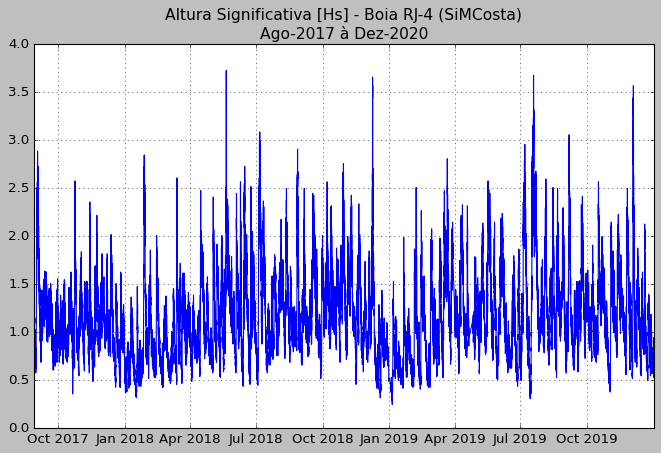

In [65]:
plt.figure(figsize=(10,6))
plt.style.use('classic')
plt.plot(dados.Hsig, linestyle='-')
plt.xlim(dados.index.min(), dados.index.max())
plt.title('Altura Significativa [Hs] - Boia RJ-4 (SiMCosta)\nAgo-2017 à Dez-2020', fontsize=14)
plt.grid()

<p> <strong> Esse plot em si não nos diz muito. Vamos verificar a autocorrelação para observar as tendências da série temporal. <strong> </p>

<Figure size 1920x960 with 0 Axes>

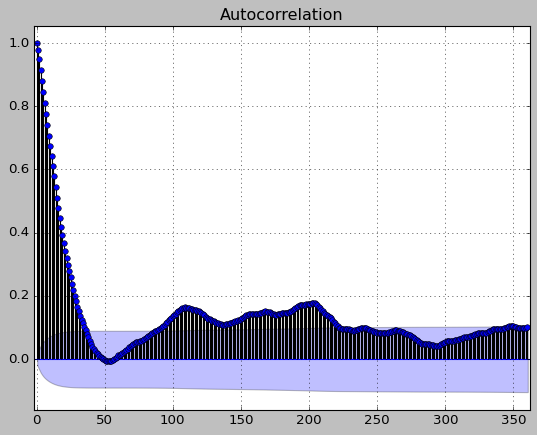

In [256]:
hsig = dados.Hsig.resample('2H').mean().interpolate(method ='linear', limit_direction ='forward')
plt.figure(figsize=(24,12))
plt.style.use('classic')
plot_acf(hsig, lags=360)
plt.xlim(-2,362)
plt.grid(linestyle=':')

plt.show()

<p> Provavelmente a série temporal é <strong>não estacionária</strong> já que a autocorrelação atinge valores insignificantes muito rápido.

A série também tem <strong>sazonalidade</strong> já que a autocorrelação sobe e desce. 
</p>
<font size='3' color='red'> Logo, o ideal a se fazer aqui é fazer um detrend e dessazonalizar! </font>
<font size='3'> Se eu quiser analisar essa série temporal mais adequadamente. </font>

In [221]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = hsig
result = seasonal_decompose(series, model='multiplicative')

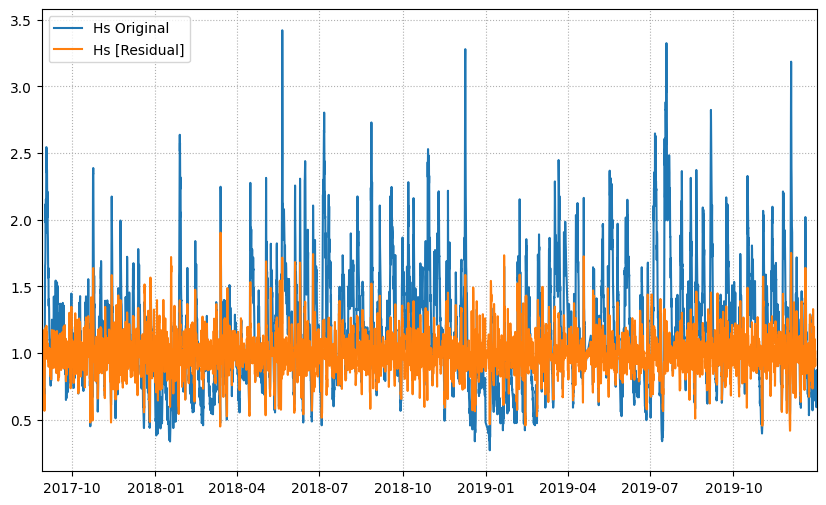

In [238]:
# plotando o resultado do residual
plt.figure(figsize=(10,6))
plt.style.use('default')
plt.plot(hsig, label='Hs Original')
plt.plot(result.resid, label='Hs [Residual]')
plt.grid(linestyle=':')
plt.xlim(result.resid.index.min(),result.resid.index.max())
plt.legend()
plt.show()

<Figure size 1920x960 with 0 Axes>

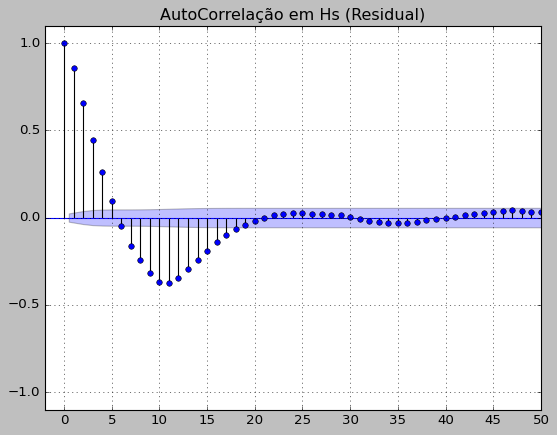

In [235]:
mask = result.resid.isnull()

plt.figure(figsize=(24,12))
plt.style.use('classic')
plot_acf(result.resid[~mask], lags=50)
plt.xlim(-2,50)
plt.xticks(np.arange(0,51,5))
plt.ylim(-1.1,1.1)
plt.grid(linestyle=':')
plt.title('AutoCorrelação em Hs (Residual)')
plt.show()

Os 6 primeiros lags, que são relativos ao período das 18 horas mostram que existe uma autocorrelação bem positiva entre os valores. A partir do lag7 até o 20 (entre 14 e 60 horas) a autocorrelação é ligeiramente negativa. 

<font color='purple'> <strong> Isso não tem relação com a aceleração e dessaceleração? </font>